In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import re
import sklearn
from sklearn.linear_model import LinearRegression
from datetime import datetime
import time
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

# функции для работы с временем: перевод в форматы timestamp и date
totimestamp = lambda s, f: np.int32(time.mktime(datetime.strptime(s, f).timetuple()))
todate = lambda x: datetime.fromtimestamp(x)

## Данные
### info dataset
+ <code>catalog_num</code> — каталожный номер
+ <code>letters</code> — буквы на монете
+ <code>mint</code> — монетный двор
+ <code>circulation</code> — тираж
+ <code>metal</code> — металл
+ <code>weight</code> — вес монеты (г.)
+ <code>pure_metal_content</code> — содержание чистого металла в монете (г.)
+ <code>diameter</code> — диаметр (мм.)
+ <code>obverse</code> — надпись на лицевой стороне
+ <code>reverse</code> — надпись на обратной стороне
+ <code>coin_name</code> — название монеты

### Auction trades dataset
+ <code>state</code> — сохранность
 + G — Good
 + VG — Very Good
 + FALSE — Fine (должно быть F, но R посчитал это FALSE)
 + VF — Very Fine
 + XF — Extra Fine
 + AU — Almost Uncirculated
 + UNC — Uncirculated
 + Proof — Идеальное
+ <code>auction</code> — название аукциона
+ <code>buyer</code> — ник покупателя
+ <code>n_bid</code> — количество заявок на аукционе
+ <code>price</code> — цена сделки
+ <code>date</code> — дата сделки
+ <code>coin_name</code> — название монеты

In [160]:
# считываю данные: серебро Николая II
df = pd.read_csv('Nick2_slv.csv', encoding='cp1251')
info = pd.read_csv('infoNick2_slv.csv', encoding='cp1251')
info.head(7)

,catalog_num,letters,mint,circulation,metal,weight,pure_metal_content,diameter,obverse,reverse,coin_name
0,Биткин-100; Конрос-146/75,СПБ ФЗ,Санкт-Петербургский,7 750 020 шт.,серебро (проба 500/1000),"3,6 г.","1,8 г.",22 мм.,в середине Малый Государственный Герб Российск...,"слева вдоль края монеты лавровая ветвь, справа...","20 копеек, 1901 год"
1,Биткин-102; Конрос-146/77,СПБ АР,Санкт-Петербургский,NaN,серебро (проба 500/1000),"3,6 г.","1,8 г.",22 мм.,в середине Малый Государственный Герб Российск...,"слева вдоль края монеты лавровая ветвь, справа...","20 копеек, 1902 год"
2,Биткин-103; Конрос-146/78,СПБ АР,Санкт-Петербургский,10 000 014 шт.,серебро (проба 500/1000),"3,6 г.","1,8 г.",22 мм.,в середине Малый Государственный Герб Российск...,"слева вдоль края монеты лавровая ветвь, справа...","20 копеек, 1903 год"
3,Биткин-104; Конрос-146/79,СПБ АР,Санкт-Петербургский,13 000 010 шт.,серебро (проба 500/1000),"3,6 г.","1,8 г.",22 мм.,в середине Малый Государственный Герб Российск...,"слева вдоль края монеты лавровая ветвь, справа...","20 копеек, 1904 год"
4,Биткин-105; Конрос-146/80,СПБ АР,Санкт-Петербургский,11 000 000 шт.,серебро (проба 500/1000),"3,6 г.","1,8 г.",22 мм.,в середине Малый Государственный Герб Российск...,"слева вдоль края монеты лавровая ветвь, справа...","20 копеек, 1905 год"
5,Биткин-106; Конрос-146/81,СПБ ЭБ,Санкт-Петербургский,NaN,серебро (проба 500/1000),"3,6 г.","1,8 г.",22 мм.,в середине Малый Государственный Герб Российск...,"слева вдоль края монеты лавровая ветвь, справа...","20 копеек, 1906 год"
6,Биткин-107; Конрос-146/82,СПБ ЭБ,Санкт-Петербургский,20 000 009 шт.,серебро (проба 500/1000),"3,6 г.","1,8 г.",22 мм.,в середине Малый Государственный Герб Российск...,"слева вдоль края монеты лавровая ветвь, справа...","20 копеек, 1907 год"


In [161]:
# Есть пропуски в тираже
info.isna().sum()

catalog_num            0
letters                5
mint                   0
circulation           18
metal                  0
weight                 0
pure_metal_content     0
diameter               0
obverse                0
reverse                0
coin_name              0
dtype: int64

In [162]:
# размер датасета: всего 124 монеты
info.shape

(124, 11)

In [163]:
df.head(10)

,state,auction,buyer,n_bid,price,date,coin_name
0,VF,Wolmar VIP,lexa-udav,42,4555,2021-10-21,"10 копеек, 1895 год"
1,VF,Wolmar VIP,lexei252,15,2942,2021-09-02,"10 копеек, 1895 год"
2,VF,Wolmar VIP,cream,13,2465,2021-07-22,"10 копеек, 1895 год"
3,VF,Wolmar VIP,solid.mickey,13,3288,2021-07-01,"10 копеек, 1895 год"
4,VF,Wolmar VIP,BelsiJ,25,2772,2021-05-27,"10 копеек, 1895 год"
5,VF,Wolmar VIP,gtnh1,31,2687,2021-04-15,"10 копеек, 1895 год"
6,VF,Wolmar VIP,Karlsin,19,2927,2021-03-11,"10 копеек, 1895 год"
7,VF,Аукцион СПБ,владимирыч,106,3856,2020-12-23,"10 копеек, 1895 год"
8,VF,Аукцион СПБ,kostyakoks76,157,2667,2020-11-25,"10 копеек, 1895 год"
9,VF,Аукцион СПБ,nnn,136,1918,2020-05-27,"10 копеек, 1895 год"


In [164]:
# есть пропуски в покупателях — это не особо важно
df.isna().sum()

state          0
auction        0
buyer        534
n_bid          0
price          0
date           0
coin_name      0
dtype: int64

In [165]:
# 185931 — количество сделок
df.shape

(185931, 7)

In [166]:
# добавление временных фичей 
df['timestamp'] = df['date'].map(lambda x: totimestamp(x, f="%Y-%m-%d"))
df['date'] = df['timestamp'].map(todate)

In [167]:
df.head()

,state,auction,buyer,n_bid,price,date,coin_name,timestamp
0,VF,Wolmar VIP,lexa-udav,42,4555,2021-10-21,"10 копеек, 1895 год",1634763600
1,VF,Wolmar VIP,lexei252,15,2942,2021-09-02,"10 копеек, 1895 год",1630530000
2,VF,Wolmar VIP,cream,13,2465,2021-07-22,"10 копеек, 1895 год",1626901200
3,VF,Wolmar VIP,solid.mickey,13,3288,2021-07-01,"10 копеек, 1895 год",1625086800
4,VF,Wolmar VIP,BelsiJ,25,2772,2021-05-27,"10 копеек, 1895 год",1622062800


In [170]:
# пример работы с форматом date
example_date = df.iloc[0]['date']
example_date.day_name()

'Thursday'

In [144]:
# создание фичей месяц и год
df['month'] = df['date'].map(lambda x: x.month)
df['year'] = df['date'].map(lambda x: x.year)
# кодирование сохранности монет
df.replace({'state' : {'G' : 1, 'VG' : 2, 'FALSE' : 3, 'VF' : 4, 'XF' : 5, 'AU' : 6, 'UNC' : 7, 'Proof' : 8}}, inplace=True)

In [145]:
# создание датасета с помощью группировки
ml_df = df.groupby(['coin_name', 'state'], as_index=False).agg({'price' : 'mean', 
                                                                'n_bid' : 'median', 
                                                                'timestamp' : 'max',
                                                                'auction' : 'count'})

In [146]:
# слияние группированного датасета и датасета с общей информацией о монетах
ml_df = ml_df.merge(info, how='inner', left_on='coin_name', right_on='coin_name')
ml_df.drop(['catalog_num', 'letters', 'obverse', 'reverse', 'diameter'], axis=1, inplace=True)

In [147]:
ml_df.head()

,coin_name,state,price,n_bid,timestamp,auction,mint,circulation,metal,weight,pure_metal_content
0,"1 рубль, 1895 год",3,10000.000000,1.0,1181941200,1,Санкт-Петербургский,1 100 002 шт.,серебро (проба 900/1000),20 г.,18 г.
1,"1 рубль, 1895 год",4,8019.637795,41.0,1623272400,254,Санкт-Петербургский,1 100 002 шт.,серебро (проба 900/1000),20 г.,18 г.
2,"1 рубль, 1895 год",5,25881.317647,37.0,1597870800,85,Санкт-Петербургский,1 100 002 шт.,серебро (проба 900/1000),20 г.,18 г.
3,"1 рубль, 1895 год",7,158104.250000,64.5,1413406800,12,Санкт-Петербургский,1 100 002 шт.,серебро (проба 900/1000),20 г.,18 г.
4,"1 рубль, 1896 год",2,513.857143,36.0,1277413200,7,Санкт-Петербургский,5 205 042 шт.,серебро (проба 900/1000),20 г.,18 г.


In [151]:
# заполнение отсутствующих тиражей нулями (конечно, так делать не стоит)
# еще немного предобработки данных
ml_df['circulation'] = ml_df['circulation'].fillna('0 шт.')
ml_df['circulation'] = ml_df['circulation'].map(lambda x: int(''.join(x.split())[:-3]))
ml_df['weight'] = ml_df['weight'].map(lambda x: float(x.split()[0].replace(',', '.')))
# тут регулярным выражением чистится фича, все переводится в числовой формат
ml_df['pure_metal_content'] = ml_df['pure_metal_content'].map(lambda x: float(re.split('\\s|\\/', x)[0].replace(',', '.')))
# кодирование кат фичей (предлагаю лучше использовать one-hot-encoding)
ml_df.replace({'mint' : {'Брюссельский' : 1, 'Санкт-Петербургский' : 2, 'Парижский' : 3},
               'metal' : {'серебро (проба 900/1000)' : 1, 'серебро (проба 500/1000)' : 2}}, inplace=True)

In [152]:
ml_df.head()

,coin_name,state,price,n_bid,timestamp,auction,mint,circulation,metal,weight,pure_metal_content
0,"1 рубль, 1895 год",3,10000.000000,1.0,1181941200,1,2,1100002,1,20.0,18.0
1,"1 рубль, 1895 год",4,8019.637795,41.0,1623272400,254,2,1100002,1,20.0,18.0
2,"1 рубль, 1895 год",5,25881.317647,37.0,1597870800,85,2,1100002,1,20.0,18.0
3,"1 рубль, 1895 год",7,158104.250000,64.5,1413406800,12,2,1100002,1,20.0,18.0
4,"1 рубль, 1896 год",2,513.857143,36.0,1277413200,7,2,5205042,1,20.0,18.0


In [153]:
# все типы данных числовых
ml_df.dtypes

coin_name              object
state                   int64
price                 float64
n_bid                 float64
timestamp               int32
auction                 int64
mint                    int64
circulation             int64
metal                   int64
weight                float64
pure_metal_content    float64
dtype: object

## Таргет

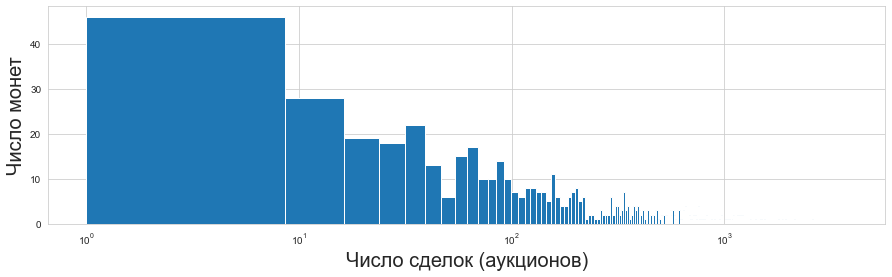

In [154]:
# проблема выбора таргета, есть ли смысл обучаться на неробастной цене?
plt.figure(figsize=(15,4))
plt.hist(ml_df['auction'], bins=500);
plt.xlabel('Число сделок (аукционов)', size=20)
plt.ylabel('Число монет', size=20)
plt.xscale('log');

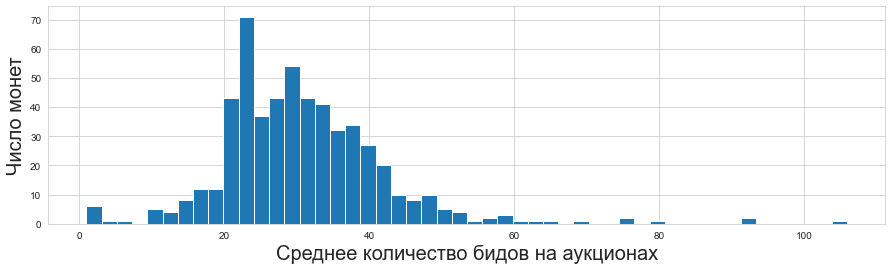

In [155]:
# насколько робастным можно считать формирование цены на аукционе с малым количеством бидов?
plt.figure(figsize=(15,4))
plt.hist(ml_df['n_bid'], bins=50);
plt.xlabel('Среднее количество бидов на аукционах', size=20);
plt.ylabel('Число монет', size=20);

In [105]:
# рассматриваем только монеты, у которых количество сделок > 20 и медианное количество бидов больше 15 
liquid_coins = ml_df[(ml_df['auction'] > 20) & (ml_df['n_bid'] > 15)]
liquid_coins.head()

,coin_name,state,price,n_bid,timestamp,auction,mint,circulation,metal,weight,pure_metal_content
1,"1 рубль, 1895 год",4,8019.637795,41.0,1623272400,254,2,1100002,1,20.0,18.0
2,"1 рубль, 1895 год",5,25881.317647,37.0,1597870800,85,2,1100002,1,20.0,18.0
5,"1 рубль, 1896 год",3,961.288462,30.5,1457643600,104,2,5205042,1,20.0,18.0
6,"1 рубль, 1896 год",4,1603.659223,29.0,1634763600,2060,2,5205042,1,20.0,18.0
7,"1 рубль, 1896 год",5,6567.646957,32.0,1601499600,575,2,5205042,1,20.0,18.0


In [106]:
# пример таргета: последняя цена, по которой совершалась сделка 
# (лучше использовать усредненное за несколько последних сделок с выкидыванием аутлайеров)
# (кроме того нельзя в усредненной цене использовать то, что предсказывается, у меня это не реализовано)
df.sort_values('timestamp', inplace=True)
target = df.groupby(['coin_name', 'state'], as_index=False).last()[['coin_name', 'state', 'price']]
target.head()

,coin_name,state,price
0,"1 рубль, 1895 год",3,10000
1,"1 рубль, 1895 год",4,27675
2,"1 рубль, 1895 год",5,18308
3,"1 рубль, 1895 год",7,138887
4,"1 рубль, 1896 год",2,503


In [ ]:
# как вариант, можно использовать скользящее окно, чтобы пройтись по всему датасету и посчитать для каждой строки
# среднюю сумму последних пяти цен за исключением максимального и минимального элемента
# например, с помощью DataFrame.rolling()

In [107]:
# склеивание таргета с основным датасетом
liquid_coins = liquid_coins.merge(target, how='inner', left_on=['coin_name', 'state'], right_on=['coin_name', 'state'])
liquid_coins = liquid_coins.rename(columns={'price_y': 'target', 'price_x' : 'price'})
liquid_coins.head()

,coin_name,state,price,n_bid,timestamp,auction,mint,circulation,metal,weight,pure_metal_content,target
0,"1 рубль, 1895 год",4,8019.637795,41.0,1623272400,254,2,1100002,1,20.0,18.0,27675
1,"1 рубль, 1895 год",5,25881.317647,37.0,1597870800,85,2,1100002,1,20.0,18.0,18308
2,"1 рубль, 1896 год",3,961.288462,30.5,1457643600,104,2,5205042,1,20.0,18.0,1137
3,"1 рубль, 1896 год",4,1603.659223,29.0,1634763600,2060,2,5205042,1,20.0,18.0,4276
4,"1 рубль, 1896 год",5,6567.646957,32.0,1601499600,575,2,5205042,1,20.0,18.0,3759


## Нормирование данных

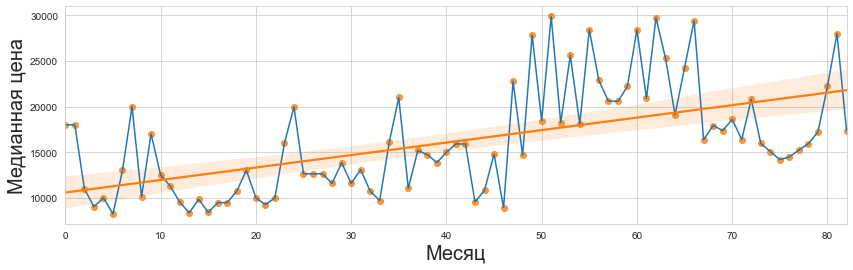

In [110]:
# зачем?
# берем конкретную монету конкретного качества, усредняем по месяцам цены и выводим график цены в рублях 
# цена уверенно растет, но это иллюзия
data = df[(df['coin_name'] == '50 копеек, 1914 год') & (df['state'] == 6)].groupby(['year', 'month'], as_index=False).median()
data['month_index'] = range(data.shape[0])
plt.figure(figsize=(14, 4))
sns.lineplot(x=data.month_index, y=data['price']);
sns.regplot(x='month_index', y='price', data=data);
plt.xlabel('Месяц', size=20);
plt.ylabel('Медианная цена', size=20);

In [68]:
# котировка рубли-доллары по дням
dollar_value = pd.read_csv('dol_price.txt')[['<DATE>', '<CLOSE>']]
dollar_value.rename(columns={'<DATE>' : 'date', '<CLOSE>' : 'dollar_value'}, inplace=True)
dollar_value.head()

,date,dollar_value
0,20110101,30.552
1,20110102,30.525
2,20110103,30.533
3,20110104,30.376
4,20110105,30.635


In [69]:
# инфляция доллара по месяцам
inflation = pd.read_csv('inflation.txt', encoding='cp1251', sep='\t')[['Дата выпуска', 'Время']]
inflation.rename(columns={'Дата выпуска' : 'timestamp', 'Время' : 'inf_value'}, inplace=True)
inflation.head()

,timestamp,inf_value
0,10.12.2021 (нояб),"0,8%"
1,10.11.2021 (окт),"0,9%"
2,13.10.2021 (сент),"0,4%"
3,14.09.2021 (авг),"0,3%"
4,11.08.2021 (июль),"0,5%"


In [71]:
# перевод времени
dollar_value['timestamp'] = dollar_value['date'].map(lambda x: totimestamp(str(x), "%Y%m%d"))
dollar_value.drop('date', axis=1, inplace=True)

In [72]:
# соединяем котировки и датасет
df = df.merge(dollar_value, how='inner', on='timestamp')
# перевод рублей в доллары
df['dollar_price'] = df['price'] / df['dollar_value']
df.head()

,state,auction,buyer,n_bid,price,date,coin_name,timestamp,month,year,dollar_value,dollar_price
0,7,Wolmar Стандарт,amok,9,212,2011-01-02,"15 копеек, 1914 год",1293915600,1,2011,30.525,6.945127
1,5,Конрос,honda129,85,510,2011-01-07,"5 копеек, 1898 год",1294347600,1,2011,30.750,16.585366
2,5,Конрос,kremen,33,110,2011-01-07,"20 копеек, 1915 год",1294347600,1,2011,30.750,3.577236
3,4,Конрос,kremen,39,102,2011-01-07,"15 копеек, 1913 год",1294347600,1,2011,30.750,3.317073
4,4,Конрос,ВВ42,32,113,2011-01-07,"20 копеек, 1909 год",1294347600,1,2011,30.750,3.674797


In [73]:
# обработка данных об инфляции
inflation['timestamp'] = inflation['timestamp'].map(lambda x: totimestamp(re.split('\\s\\(', x)[0], f='%d.%m.%Y'))
inflation['inf_value'] = inflation['inf_value'].map(lambda x: float(x[:-1].replace(',', '.')))
inflation['inf_coef'] = 1 - inflation['inf_value'] / 100

In [74]:
n_month = inflation.shape[0] - 1
inflation.at[n_month, 'inf_coef'] = 1
inflation.sort_values('timestamp', inplace=True)
for i in range(1, n_month + 1):
    inflation.at[n_month - i, 'inf_coef'] = inflation.iloc[i - 1]['inf_coef'] * inflation.iloc[i]['inf_coef']

In [75]:
# перевод времени
inflation = inflation.set_index('timestamp')
inflation = inflation.reindex(range(inflation.index[0], inflation.index[-1] + 86400, 86400), method='pad')

In [76]:
# соединяем с датасетом
df = df.merge(inflation, how='inner', on='timestamp')

In [77]:
# нормирование по инфляции
df['inf_dollar_price'] = df['dollar_price'] * df['inf_coef']
df.drop(['inf_value'], axis=1, inplace=True)
df.head()

,state,auction,buyer,n_bid,price,date,coin_name,timestamp,month,year,dollar_value,dollar_price,inf_coef,inf_dollar_price
0,5,Конрос,xorek016,12,93,2011-01-14,"15 копеек, 1915 год",1294952400,1,2011,29.9921,3.100817,1.0,3.100817
1,5,Конрос,1269532,16,157,2011-01-14,"10 копеек, 1914 год",1294952400,1,2011,29.9921,5.234712,1.0,5.234712
2,4,Конрос,1269532,40,100,2011-01-14,"10 копеек, 1912 год",1294952400,1,2011,29.9921,3.334211,1.0,3.334211
3,6,Конрос,xorek016,13,138,2011-01-14,"20 копеек, 1915 год",1294952400,1,2011,29.9921,4.601212,1.0,4.601212
4,4,Конрос,SANGOLD1,18,127,2011-01-14,"20 копеек, 1911 год",1294952400,1,2011,29.9921,4.234448,1.0,4.234448


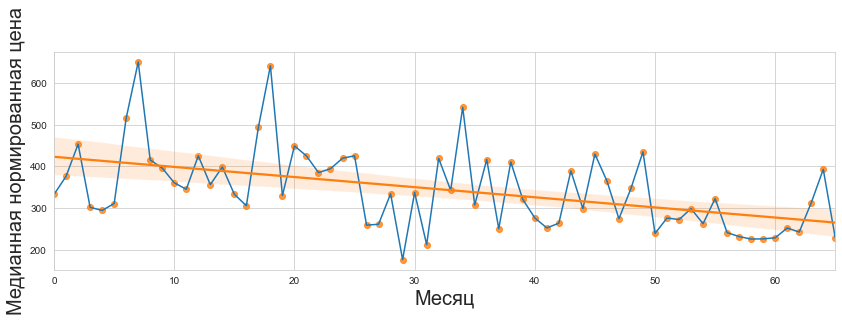

In [78]:
# график нормированной цены на самом деле скорее убывает, чем возрастает
data = df[(df['coin_name'] == '50 копеек, 1914 год') & (df['state'] == 6)].groupby(['year', 'month'], as_index=False).median()
data['month_index'] = range(data.shape[0])
plt.figure(figsize=(14, 4))
sns.lineplot(x=data.month_index, y=data['inf_dollar_price']);
sns.regplot(x='month_index', y='inf_dollar_price', data=data);
plt.xlabel('Месяц', size=20);
plt.ylabel('Медианная нормированная цена', size=20);

In [932]:
# идея - отбросить максимальное количество информации, влияющих на цену (инфляция, валюта, металл, время)
# задача - оценить вклад коллекционной (исторической) ценности в стоимость монеты 

# по чему еще можно нормировать?
# какие еще преобразования можно применить?